# IERG 6130 Assignment 3: Policy Gradient

*2019-2020 2nd term, IERG 6130: Reinforcement Learning and Beyond. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao.*



| Student Name | Student ID |
| :----: | :----: |
| TYPE_YOUR_NAME_HERE | TYPE_YOUR_STUDENT_ID_HERE |

------

Welecome to the assignment 3 of our RL course. 

You need to go through this self-contained notebook, which contains many TODOs in part of the cells and has special `[TODO]` signs. You need to finish all TODOs. Some of them may be easy such as uncommenting a line, some of them may be difficult such as implementing a function. You can find them by searching the `[TODO]` symbol. However, we suggest you to go through the notebook step by step, which would give you a better understanding of the content.

You are encouraged to add more code on extra cells at the end of the each section to investigate the problems you think interesting. At the end of the file, we left a place for you to optionaly write comments.

Please report any code bugs to us via cuhkrlcourse@googlegroups.com or via github issue. Before you submission, remember to check the submit instruction at the directory of this assignment and make sure the required contents are included in your submission.

Before you get start, remember to follow the instruction at https://github.com/cuhkrlcourse/ierg6130 to setup your environment.

We will cover the following knowledege in this assignment:

1. Basic policy gradient method
2. Policy gradient with baseline
3. Actor-critic framework

You need to install some packages.
1. Install `yaml` package via `pip install pyyaml` to print training information.
2. Install `pandas` via `pip install pandas` to organize the learning progress.
3. Install `matplotlib` via `pip install matplotlib` to visualize the learning result.
4. Install `seaborn` via `pip install seaborn` to visualize the learning result (beautiful than matplotlib).

------

## Section 1: Basic reinforcement learning pipeline

(5 / 100 points)

In this section, we will prepare several functions for evaulation, training RL algorithms. We will also build an `AbstractTrainer` class used as a general framework which left blanks for policy gradient methods.

A essential difference of this assignment compared to the previous is that: the sampling and the optimization are splited into two phase. In each training iteration, the agent first collects a batch of samples followed by conducting the policy optimization. This modification allows us to have a clear view on the training process.

In [1]:
# Run this cell without modification

import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

from utils import *

In [2]:
# Run this cell without modification

def run(trainer_cls, config=None, reward_threshold=None):
    """Run the trainer and report progress, agnostic to the class of trainer
    :param trainer_cls: A trainer class 
    :param config: A dict
    :param reward_threshold: the reward threshold to break the training
    :return: The trained trainer and a dataframe containing learning progress
    """
    assert inspect.isclass(trainer_cls)
    if config is None:
        config = {}
    trainer = trainer_cls(config)
    config = trainer.config
    start = now = time.time()
    stats = []
    print("=== {} {} Training Start ===".format(trainer_cls.__name__, config["env_name"]))
    pretty_print({"Config": config})
    for i in range(config['max_iteration'] + 1):
        stat = trainer.train()
        stats.append(stat or {})
        if i % config['evaluate_interval'] == 0 or \
                i == config["max_iteration"]:
            reward = trainer.evaluate(config["evaluate_num_episodes"])
            stat["evaluate_reward"] = reward
            print("=== {} {} Iteration {} ===".format(
                trainer_cls.__name__, config["env_name"], i)
            )
            pretty_print({"Training Progress": stat})
            now = time.time()
        if reward_threshold is not None and reward > reward_threshold:
            print("In {} iteration, current mean episode reward {:.3f} is "
                  "greater than reward threshold {}. Congratulation! Now we "
                  "exit the training process.".format(
                i, reward, reward_threshold))
            break
    stats = pd.DataFrame(stats)
    return trainer, stats


In [3]:
# Solve the TODOs and remove `pass`

default_config = dict(
    env_name="CartPole-v0",
    
    max_iteration=1000,
    max_episode_length=1000,
    
    train_batch_size=1000,
    gamma=0.99,
    learning_rate=0.01,
    seed=0,
    
    evaluate_interval=10,
    evaluate_num_episodes=50
)


class AbstractTrainer:
    """This is the abstract class for value-based RL trainer. We will inherent
    the specify algorithm's trainer from this abstract class, so that we can
    reuse the codes.
    """

    def __init__(self, config=None):
        self.config = check_and_merge_config(config or {}, default_config)

        # Create the environment
        self.env_name = self.config['env_name']
        self.env = gym.make(self.env_name)
        if "ram" in self.env_name:  # Special process for Atari games
            self.env = wrap_deepmind_ram(self.env)

        # Apply the random seed
        self.seed = self.config["seed"]
        seed_everything(self.seed)
        self.env.seed(self.seed)

        assert isinstance(self.env.observation_space,
                          gym.spaces.Box), self.env.observation_space
        self.obs_dim = self.env.observation_space.shape[0]
        self.discrete_obs = True

        assert isinstance(self.env.action_space, gym.spaces.discrete.Discrete)
        self.act_dim = self.env.action_space.n

        self.iteration = 0
        self.start_time = time.time()
        self.iteration_time = self.start_time
        self.total_timesteps = 0
        self.total_episodes = 0

        # build the model
        self.build_model()

    def build_model(self):
        raise NotImplementedError()

    # ===== Helper functions =====
    def evaluate(self, num_episodes=10, render=False):
        """Evaluate the agents for num_episodes episodes."""
        return evaluate_agent(self, self.env, num_episodes, render)

    def to_tensor(self, array):
        """Preprocess the observation."""
        raise NotImplementedError()

    def compute_action(self, observation):
        """Return the action, which can feed to self.env.step immediately."""
        raise NotImplementedError()

    def compute_values(self, observation):
        raise NotImplementedError()

    def compute_log_probs(self, observation):
        raise NotImplementedError()

    # ===== Training-related functions =====
    def collect_samples(self):
        """Here we define the pipeline to collect sample even though
        any specify functions are not implemented yet.
        """
        iter_timesteps = 0
        iter_episodes = 0
        episode_lens = []
        episode_rewards = []
        episode_obs_list = []
        episode_act_list = []
        episode_reward_list = []
        while iter_timesteps <= self.config["train_batch_size"]:
            obs_list, act_list, reward_list = [], [], []
            obs = self.env.reset()
            steps = 0
            episode_reward = 0
            while True:
                act = self.compute_action(obs)
                next_obs, reward, done, _ = self.env.step(act)

                obs_list.append(obs)
                act_list.append(act)
                reward_list.append(reward)

                obs = next_obs.copy()
                steps += 1
                episode_reward += reward
                if done or steps > self.config["max_episode_length"]:
                    break
            iter_timesteps += steps
            iter_episodes += 1
            episode_rewards.append(episode_reward)
            episode_lens.append(steps)
            episode_obs_list.append(np.array(obs_list, dtype=np.float32))
            episode_act_list.append(np.array(act_list, dtype=np.float32))
            episode_reward_list.append(np.array(reward_list, dtype=np.float32))
        
        # [TODO] Uncomment everything below and understand the data structure:
        # The return `samples` is a dict that contains several fields.
        # Each field (key-value pair) contains a list.
        # Each element in list is a list represent the data in one trajectory (episode).
        # Each episode list contains the data of that field of all time steps in that episode.
        # The return `sample_info` is a dict contains logging item name and its value.
        
        samples = {
            "obs": episode_obs_list,
            "act": episode_act_list,
            "reward": episode_reward_list
        }
        
        #pass
        
        sample_info = {
            "iter_timesteps": iter_timesteps,
            "iter_episodes": iter_episodes,
            "performance": np.mean(episode_rewards),  # help drawing figures
            "training_episode_length": {
                "mean": float(np.mean(episode_lens)),
                "max": float(np.max(episode_lens)),
                "min": float(np.min(episode_lens))
            },
            "training_episode_reward": {
                "mean": float(np.mean(episode_rewards)),
                "max": float(np.max(episode_rewards)),
                "min": float(np.min(episode_rewards))
            }
        }
        return samples, sample_info

    def process_samples(self, samples):
        raise NotImplementedError()

    def update_model(self, processed_samples):
        raise NotImplementedError()

    # ===== Training iteration =====
    def train(self):
        """Here we defined the training pipeline using the abstract
        functions."""
        info = dict(iteration=self.iteration)

        # [TODO] Uncomment the following block and go through the learning 
        # pipeline.
        
        # Collect samples
        samples, sample_info = self.collect_samples()
        info.update(sample_info)

        # Process samples
        processed_samples, processed_info = self.process_samples(samples)
        info.update(processed_info)

        # Update the model
        update_info = self.update_model(processed_samples)
        info.update(update_info)
        
        #pass

        now = time.time()
        self.iteration += 1
        self.total_timesteps += info["iter_timesteps"]
        self.total_episodes += info["iter_episodes"]
        info["iter_time"] = now - self.iteration_time
        info["total_time"] = now - self.start_time
        info["total_episodes"] = self.total_episodes
        info["total_timesteps"] = self.total_timesteps
        self.iteration_time = now
        return info


In [4]:
# Run this cell without modification

class TestAbstractTrainer(AbstractTrainer):
    def build_model(self):
        pass
    def compute_action(self, _):
        return np.random.choice(self.act_dim)
test_trainer = TestAbstractTrainer()
s, s_info = test_trainer.collect_samples()
assert len(s["obs"]) == s_info["iter_episodes"]
for i in range(len(s["obs"])):
    assert s["obs"][i].shape[0] <= default_config["max_episode_length"]
    assert len(s["act"][i]) == len(s["obs"][i]) == len(s["reward"][i])
assert abs(s_info["training_episode_length"]["mean"] * s_info["iter_episodes"]
           - s_info["iter_timesteps"]) < 1
print("Test Passed!")

Test Passed!


Now we have an abstract trainer class here. We have abstracted the learning process into three phases: Collect samples, process samples and update the model. In the following sections, we will continue to fulfill the blank functions.

## Section 2: Basic policy gradient method

(40 / 100 points)

Unlike supervised learning, in RL setting the signal: reward and the output of neural network: the action distribution parameter (like the logits in discrete case or the mean in continous case) have no direct connection in terms of gradient. That is, you can't compute the gradient from the environment to your network output. 

To leverage the powerful tool of gradient descent, scientists innovated a technique called policy gradient, which is computed on top of the rewards and policy network's output. Scientists prove that: the policy gradient is the gradient of expected return w.r.t. the output. So that by applying gradient descent to gradient descent algorithm you can optimize your policy network and maximize the expected return (or minimize the negative of expected return).

Concretely, if we consider the expected return, the value we want to maximize, is:

$$Q = \mathbb E_{\text{possible trajectories}} \sum_t r(a_t, s_t) = \sum_{s_0, a_0,..} p(s_0, a_0, ..., s_t, a_t) r(s_0, a_0, ..., s_t, a_t) = \sum_{\tau} p(\tau)r(\tau)$$ 

wherein $\sum_t r(a_t, s_t) = r(s_0, a_0, ..., s_t, a_t) = r(\tau)$ is the trajectory return. We use $\tau$ to represent a trajectory $s_0, a_0, ..., s_t, a_t$. Note that we remove the discount factor for simplicity.

Since we want to maximize Q, we can simply compute the gradient from Q to parameter $\theta$ (which is included in the action probability $p(a_t)$):

$$\nabla_\theta Q = \nabla_\theta \sum_{\tau} p(\tau)r(\tau) = \sum_{\tau} r(\tau) \nabla_\theta p(\tau)$$

Scientists use a famous trick to deal with the gradient of probability of trajectory: $\nabla_\theta p(\tau) = p(\tau)\cfrac{\nabla_\theta p(\tau)}{p(\tau)} = p(\tau)\nabla_\theta \log p(\tau)$. 

The reason for this trick is that the probability of a trajectory is the product of all related probabilities of states and actions. So introducing a log term can change the production to summation: $p_\theta(\tau) = p(s_0, a_0, ...) = p(s_0) \prod_t \pi_\theta (a_t|s_t) p(s_{t+1}|s_t, a_t)$ Now we can expand the log of product above to sum of log:

$$\log p_\theta (\tau) = \log p(s_1) + \sum_t \log \pi_\theta(a_t|s_t) + \sum_t \log p(s_{t+1}|s_t, a_t)$$

You will find that the first and third term are not related to the parameter of policy $\pi_\theta(\cdot)$. So when we back to $\nabla_\theta Q$, we find 

$$\nabla_\theta Q = \sum_{\tau} r(\tau) \nabla_\theta p(\tau) =  \sum p_\theta(\tau) ( \sum_t  \nabla_\theta \log \pi_\theta(a_t|s_t) ) r(\tau) d\tau$$

The probability of trajectory is included when we sampled sufficient data from environment (Yes, so REINFORCE is a Monte Carlo algorithm) so the final form of policy gradient is:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'=t} \gamma^{t'-t} r(s_{i,t'}, a_{i,t'}) )]$$

This algorithm is called REINFORCE algorithm, which is a Monte Carlo Policy Gradient algorithm having long history. In this section, we will implement the it using pytorch.

The policy network is composed by two parts: a basic MLP serve as function approximator which predict the probabilities of actions given the observation; and a distribution layer building upon the MLP to wrap the raw logits output of neural network to a distribution and provides API for action sampling and log probability retrieving.

In [5]:
# Run this cell without modification

class Net(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_units=128):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(obs_dim, hidden_units)
        self.fc1 = nn.Linear(hidden_units, act_dim)

    def forward(self, x):
        x = x.type_as(self.fc0.bias)
        x = F.relu(self.fc0(x))
        x = self.fc1(x)
        x= F.softmax(x)
        return x


class CategoricalPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_units=128):
        super(CategoricalPolicy, self).__init__()
        self.network = Net(obs_dim, act_dim, hidden_units)

    def forward(self, obs):
        logit = self.network(obs)
        
        # [TODO] Create an object of the class "Categorical" in torch 
        # package "distributions". Then sample an action from it.
        action = None
        p = torch.distributions.Categorical(logit)
        action = p.sample()
        #pass
        
        return action

    def log_prob(self, obs, act):
        logits = self.network(obs)
        
        # [TODO] Create an object of the class "Categorical" in torch 
        # package "distributions". Then collect the log probability of
        # the action in this distribution.
        log_prob = None
        p = torch.distributions.Categorical(logits)
        log_prob = p.log_prob(act)
        #pass
        
        return log_prob

# Not that we do not implement GaussianPolicy here. So we can't
# apply our algorithm to the environment with continous action.


In [18]:
# Solve the TODOs and remove `pass`

pg_default_config = merge_config(dict(
    normalize_advantage=True,
    clip_gradient=10.0,
    hidden_units=64,
), default_config)


class PGTrainer(AbstractTrainer):
    def __init__(self, config=None):
        config = check_and_merge_config(config or {}, pg_default_config)
        super().__init__(config)

    def build_model(self):
        """Build the policy network and related optimizer"""
        # Detect whether you have GPU or not. Remember to call X.to(self.device)
        # if necessary.
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # [TODO] Build the policy network using CategoricalPolicy
        # Hint: Remember to pass config["hidden_units"], and set policy network
        #  to the device you are using.
        self.policy = None
        self.policy = CategoricalPolicy(self.obs_dim, self.act_dim,self.config["hidden_units"]).to(self.device)
        #pass
        
        # Build the Adam optimizer.
        self.optimizer = torch.optim.Adam(
            self.policy.parameters(),
            lr=self.config["learning_rate"]
        )

    def to_tensor(self, array):
        """Transform a numpy array to a pytorch tensor"""
        return torch.from_numpy(array).to(self.device)

    def to_array(self, tensor):
        """Transform a pytorch tensor to a numpy array"""
        return tensor.cpu().detach().numpy()

    def compute_action(self, observation):
        """Compute the action for single observation"""
        assert observation.ndim == 1
        # [TODO] Sample an action from action distribution given by the policy
        # Hint: The input of policy network is a batch of data, so you need to
        #  expand the first dimension of observation before feeding it to policy network.
        action = None
        observation = self.to_tensor(observation)
        observation = observation.view(1,-1)
        action = self.policy(observation)
        return action.item()
        #pass

    def compute_log_probs(self, observation, action):
        """Compute the log probabilities of a batch of state-action pair"""
        # [TODO] Using the function of policy network to get log probs.
        # Hint: Remember to transform the data into tensor before feeding it.
        observation = self.to_tensor(observation)
        action = self.to_tensor(action)
        log_probs =  self.policy.log_prob(observation,action)
        return log_probs
        #pass

    def process_samples(self, samples):
        """Process samples and add advantages in it"""
        values = []
        for reward_list in samples["reward"]:
            # reward_list contains rewards in one episode
            returns = np.zeros_like(reward_list, dtype=np.float32)
            Q = 0
            
            # [TODO] Scan the episode in a reverse order and compute the
            # discounted return at each time step. Fill the array `returns`
            # Hint: returns[n-1] = r_n-1
            #       returns[n-2] = r_n-2 + gamma * r_n-1
            #       ...
            #       returns[0] = r_0 + gamma * r_1 + gamma^2 * r_2 + ...
            #  wherein n is len(reward_list)
            for i,reward in enumerate(reversed(reward_list)):
                Q = reward+self.config["gamma"]*Q
                returns[-1-i] = Q
            #pass
            values.append(returns)

        # We call the values advantage here.
        advantages = np.concatenate(values)

        if self.config["normalize_advantage"]:
            # [TODO] normalize the advantage so that it's mean is
            # almost 0 and the its standard deviation is almost 1.
            advantages -= np.mean(advantages)
            advantages /= np.std(advantages)
            #pass
        
        samples["advantages"] = advantages
        return samples, {}

    def update_model(self, processed_samples):
        """A wrapper function, call self.update_policy"""
        return self.update_policy(processed_samples)

    def update_policy(self, processed_samples):
        """Update the policy network"""
        advantages = self.to_tensor(processed_samples["advantages"])
        flat_obs = np.concatenate(processed_samples["obs"])
        flat_act = np.concatenate(processed_samples["act"])

        self.policy.train()
        self.optimizer.zero_grad()

        log_probs = self.compute_log_probs(flat_obs, flat_act)

        assert log_probs.shape == advantages.shape, "log_probs shape {} is not " \
            "compatible with advantages {}".format(log_probs.shape, advantages.shape)
        
        # [TODO] Compute the loss using log probabilities and advantages.
        loss = None
        loss = -(log_probs*advantages).sum() 
        #pass
        
        loss.backward()
        
        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.policy.parameters(), self.config["clip_gradient"]
        )

        self.optimizer.step()
        self.policy.eval()
        update_info = {
            "policy_loss": loss.item(),
            "mean_log_prob": torch.mean(log_probs).item(),
            "mean_advantage": torch.mean(advantages).item()
        }
        return update_info


In [19]:
# Run this cell without modification

# Test advantage computing
test_trainer = PGTrainer({"normalize_advantage": False})
test_trainer.train()
fake_sample = {"reward": [[2, 2, 2, 2, 2]]}
assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["reward"][0],
    fake_sample["reward"][0]
)
assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["advantages"],
    np.array([9.80199, 7.880798, 5.9402, 3.98, 2.], dtype=np.float32)
)

# Test advantage normalization
test_trainer = PGTrainer(
    {"normalize_advantage": True, "env_name": "LunarLander-v2"})
test_adv = test_trainer.process_samples(fake_sample)[0]["advantages"]
assert_almost_equal(test_adv.mean(), 0.0)
assert_almost_equal(test_adv.std(), 1.0)

# Test the shape of functions' returns
fake_observation = np.array([
    test_trainer.env.observation_space.sample() for i in range(10)
])
fake_action = np.array([
    test_trainer.env.action_space.sample() for i in range(10)
])
assert test_trainer.to_tensor(fake_observation).shape == torch.Size([10, 8])
assert np.array(test_trainer.compute_action(fake_observation[0])).shape == ()
assert test_trainer.compute_log_probs(fake_observation, fake_action).shape == \
       torch.Size([10])

print("Test Passed!")


C:\Anaconda3\envs\ierg6130\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Test Passed!


In [21]:
# Run this cell without modification

pg_trainer_no_na, pg_result_no_na = run(PGTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
    normalize_advantage=False,  # <<== Here!
), 195.0)


=== PGTrainer CartPole-v0 Training Start ===
Config:
  checked: true
  clip_gradient: 10.0
  env_name: CartPole-v0
  evaluate_interval: 10
  evaluate_num_episodes: 50
  gamma: 0.99
  hidden_units: 64
  learning_rate: 0.01
  max_episode_length: 200
  max_iteration: 1000
  normalize_advantage: false
  seed: 0
  train_batch_size: 200



C:\Anaconda3\envs\ierg6130\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


=== PGTrainer CartPole-v0 Iteration 0 ===
Training Progress:
  evaluate_reward: 23.18
  iter_episodes: 10
  iter_time: 0.11746907234191895
  iter_timesteps: 217
  iteration: 0
  mean_advantage: 11.939602851867676
  mean_log_prob: -0.6919979453086853
  performance: 21.7
  policy_loss: 1793.763427734375
  total_episodes: 10
  total_time: 0.11746907234191895
  total_timesteps: 217
  training_episode_length:
    max: 32.0
    mean: 21.7
    min: 9.0
  training_episode_reward:
    max: 32.0
    mean: 21.7
    min: 9.0

=== PGTrainer CartPole-v0 Iteration 10 ===
Training Progress:
  evaluate_reward: 58.24
  iter_episodes: 3
  iter_time: 0.11713433265686035
  iter_timesteps: 246
  iteration: 10
  mean_advantage: 34.35287094116211
  mean_log_prob: -0.6174345016479492
  performance: 82.0
  policy_loss: 5194.11328125
  total_episodes: 63
  total_time: 1.9001731872558594
  total_timesteps: 2549
  training_episode_length:
    max: 123.0
    mean: 82.0
    min: 59.0
  training_episode_reward:
    m

In [22]:
# Run this cell without modification

pg_trainer_na, pg_result_na = run(PGTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
    normalize_advantage=True,  # <<== Here!
), 195.0)


=== PGTrainer CartPole-v0 Training Start ===
Config:
  checked: true
  clip_gradient: 10.0
  env_name: CartPole-v0
  evaluate_interval: 10
  evaluate_num_episodes: 50
  gamma: 0.99
  hidden_units: 64
  learning_rate: 0.01
  max_episode_length: 200
  max_iteration: 1000
  normalize_advantage: true
  seed: 0
  train_batch_size: 200



C:\Anaconda3\envs\ierg6130\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


=== PGTrainer CartPole-v0 Iteration 0 ===
Training Progress:
  evaluate_reward: 27.24
  iter_episodes: 10
  iter_time: 0.0750279426574707
  iter_timesteps: 217
  iteration: 0
  mean_advantage: -1.5381843354589364e-08
  mean_log_prob: -0.6919979453086853
  performance: 21.7
  policy_loss: 0.11937487125396729
  total_episodes: 10
  total_time: 0.0750279426574707
  total_timesteps: 217
  training_episode_length:
    max: 32.0
    mean: 21.7
    min: 9.0
  training_episode_reward:
    max: 32.0
    mean: 21.7
    min: 9.0

=== PGTrainer CartPole-v0 Iteration 10 ===
Training Progress:
  evaluate_reward: 67.16
  iter_episodes: 2
  iter_time: 0.0937807559967041
  iter_timesteps: 248
  iteration: 10
  mean_advantage: -1.509343405814434e-07
  mean_log_prob: -0.6186388731002808
  performance: 124.0
  policy_loss: -0.6669702529907227
  total_episodes: 67
  total_time: 1.6582772731781006
  total_timesteps: 2526
  training_episode_length:
    max: 169.0
    mean: 124.0
    min: 79.0
  training_epis

Text(0.5, 1.0, 'Policy Gradient')

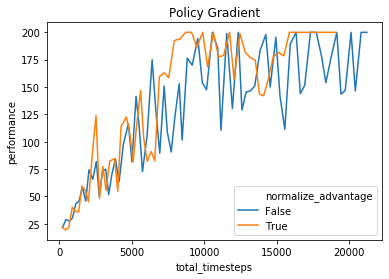

In [23]:
# Run this cell without modification

pg_result_no_na["normalize_advantage"] = False
pg_result_na["normalize_advantage"] = True
pg_result = pd.concat([pg_result_no_na, pg_result_na])
ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pg_result, hue="normalize_advantage",
)
ax.set_title("Policy Gradient")

## Section 3: Policy gradient with baseline

(25 / 100 points)

Recall the REINFORCE algorithm above. We compute the gradient of $Q = \mathop{\mathbb E} \sum_t r(a_t, s_t)$ w.r.t. the parameter to update the policy. A natural question is that, when you take an inferior action that lead to positive expected return, the policy gradient is also positive and you will update your network toward this action. At the same time a potential better action is ignored.

To tackle this problem, we introduce "baseline" when computing the policy gradient. The insight behind this is that we want to optimize the policy toward an action that are better than the average performance when taking all action into consideration at a given state.

We introduce $b_{t} = \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$ as the baseline. It average all possible actions at state $s_t$. So that the profit achieved by action $a_t$ can be evaluated via $\sum_{t'=t} \gamma^{t' -t}r(a_{t'}, s_{t'}) - b_t$

Therefore, the policy gradient becomes:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'} \gamma^{t'-t} r(s_{i,{t’}}, a_{i,t‘}) - b_{i, t})]$$

In our implementation, we estimate the baseline via an extra network `self.baseline`, which has same structure of policy network but output only a scalar value. We use the output of this network to serve as the baseline, while this network is updated by fitting the true value of expected return of current state: $\mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$

In implementation, we use a trick to match the distribution of baseline and values. During training, we first collect a batch of target values: $\{t_i= \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}\}_i$. Then we normalzie all targets to standard distribution with mean = 0 and std = 1. Then we ask the baseline network to fit such normalized targets.

When computing the advantages, instead of using the output of baseline network as the baseline $b$, we firstly match the baseline distribution with action values. The transformed baselines $b' = f(b)$ should has the same means of action values and same STD of action values too. Then we compute the advantage of current action: $adv_{i,t} = \sum_{t'} \gamma^{t'-t} r(s_{i,{t'}}, a_{i,t'}) - b'_{i, t}$

By doing this, we mitigate the instability of training baseline.

Hint: We suggest to normalize an array via: `(x - x.mean()) / max(x.std(), 1e-6)`. The max term can avoid potential risk of error.

In [ ]:
pg_with_baseline_default_config = merge_config(dict(), pg_default_config)

class PolicyGradientWithBaselineTrainer(PGTrainer):
    def __init__(self, config=None):
        config = check_and_merge_config(config or {}, pg_with_baseline_default_config)
        super().__init__(config)

    def build_model(self):
        # Build the actor in name of self.policy
        super().build_model()
        
        # [TODO] Build the baseline network using Net class.
        # Remember that you need to set the output dimension to 1.
        # Remember using model.to(device) function to move your model to GPU (if applicable)
        self.baseline = None
        pass
        
        self.baseline_loss = nn.MSELoss()
            
        self.baseline_optimizer = torch.optim.Adam(
            self.baseline.parameters(),
            lr=self.config["learning_rate"]
        )

    def process_samples(self, samples):
        # Call the original process_samples function to get advantages
        tmp_samples, _ = super().process_samples(samples)
        values = tmp_samples["advantages"]
        samples["values"] = values  # We add q_values into samples

        # [TODO] flatten the observations in all trajectories (still a numpy array)
        obs = None
        pass
        
        assert obs.ndim == 2
        assert obs.shape[1] == self.obs_dim
        
        obs = self.to_tensor(obs)
        samples["flat_obs"] = obs

        # [TODO] Compute the baseline by feeding observation to baseline network
        # Hint: baselines turns out to be a numpy array with the same shape of `values`,
        #  that is: (batch size, )
        baselines = None
        pass
        
        assert baselines.shape == values.shape
        
        # [TODO] Match the distribution of baselines to the values.
        # Hint: We expect to see baselines.std almost equals to values.std, 
        #  and baselines.mean almost equals to values.mean
        pass

        # Compute the advantage
        advantages = values - baselines
        samples["advantages"] = advantages
        process_info = {"mean_baseline": float(np.mean(baselines))}
        return samples, process_info

    def update_model(self, processed_samples):
        update_info = {}
        update_info.update(self.update_baseline(processed_samples))
        update_info.update(self.update_policy(processed_samples))
        return update_info

    def update_baseline(self, processed_samples):
        self.baseline.train()
        obs = processed_samples["flat_obs"]

        # [TODO] Normalize the values to mean=0, std=1.
        values = processed_samples["values"]
        pass
        
        values = self.to_tensor(values[:, np.newaxis])
        
        baselines = self.baseline(obs)

        self.baseline_optimizer.zero_grad()
        loss = self.baseline_loss(input=baselines, target=values)
        loss.backward()
        
        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.baseline.parameters(), self.config["clip_gradient"]
        )
        
        self.baseline_optimizer.step()
        self.baseline.eval()
        return dict(baseline_loss=loss.item())


In [ ]:
# Run this cell without modification

pg_trainer_wb, pgwb_result_wb = run(PolicyGradientWithBaselineTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
), 195.0)


In [ ]:
# Run this cell without modification

pg_result_no_na["normalize_advantage"] = False
pg_result_na["normalize_advantage"] = True
pgwb_result_wb["normalize_advantage"] = "True with Baseline"
pg_result = pd.concat([pg_result_no_na, pg_result_na, pgwb_result_wb])
ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pg_result, hue="normalize_advantage",
)
ax.set_title("Policy Gradient")

In [ ]:
# Run this cell without modification

# You should see a pop up window which display the movement of the cart and pole.
print("Average episode reward for your Policy Gradient agent in CartPole-v0: ",
      pg_trainer_wb.evaluate(1, render=True))

## Section 4: Actor-critic Method

(30 / 100 points totally)

### Section 4.1: Implement ActorCriticTrainer

(20 / 100 points)

As point out in the textbook Page 331, the difference of Actor-critic methods and policy gradient with baseline method is whether the critic (baseline) participates in the bootstrapping. In `PolicyGradientWithBaselineTrainer`, we update the baseline network by fitting the ground-truth Q values. However, in actor-critic trainer presented below, we update the critic via fitting a bootstrapped target: 

$$\delta = r_t + \gamma V(s_{t+1}) - V(s_t)$$

wherein $V$ is the values predicted by critic. In `ActorCriticTrainer`, in order to reuse the codes, we use `self.baseline` to represent the critic network.

In [ ]:
# Solve the TODOs and remove `pass`

ac_default_config = merge_config(dict(
    normalize_advantage=True,
    num_critic_updates=10,
    num_critic_update_steps=10
), pg_with_baseline_default_config)

class ActorCriticTrainer(PolicyGradientWithBaselineTrainer):
    def __init__(self, config=None):
        config = check_and_merge_config(config or {}, ac_default_config)
        super().__init__(config)
        
    def process_samples(self, samples):
        """
        In this function, we will compute the target of value function
        and also the advantage used for updating policy.
        
        First, we need to prepare data to compute the values.
        
        Consider you only collect two trajectories in samples.
        Then the data structure should be:
            samples["obs"] = [
                [
                    obs_t1_0,  <<= t=0
                    obs_t1_1,  <<= t=1
                    obs_t1_n1-1, <<= t=n1-1 
                ],  (the traj t1 has length = n1)
                [
                    obs_t2_0,
                    ...
                    obs_t2_n2-1 
                ]   (the traj t2 has length = n2)
            ]
        the whole training batch size is N = (n1 + n2).
        Then what you should do is to take store
        [
            obs_t1_1, ..., obs_t1_n1-1, ZERO, 
            obs_t2_1, ... obs_t2_n2-1, ZERO
        ]
        into `next_obs` variable, wherein ZERO is a zero array has
        same shape as any other observation.
        
        Besides, you also need to prepare a boolean array `masks`
        who has length N. It should be like:
        [
            False(0), ..., False(n1-2), True(n1-1),
            False(0), ..., False(n2-2), True(n2-1)
        ].
        It represents whether a transition is terminal transition
        and whether a observation in next_obs should be masked.
        We will used it when computing the bootstrapped values:
        
            value_t = reward_t + gamma * value_t+1 * (1 - masks)
            
        So that we will not consider the impact of value_t+1
        in terminal state.
        
        Then, we need to compute the values and advantage based on 
        the data collected and form a processed_samples for the 
        consecetive .
        """
        # Define the sum of all trajectory length as N (train batch size)
        N = sum([len(traj) for traj in samples["obs"]])
        n = len(samples["obs"][0])  # the first traj length
        
        # [TODO] Create an array named next_obs.
        # In each trajectory, take the observations from second
        # transitions to the end. Fill an extra all zero observation
        # at the end of trajectory to align next_obs with others.
        next_obs = []
        for obs_list in samples["obs"]:
            pass
            
        next_obs = np.array(next_obs)
        
        assert next_obs.shape == (N, self.obs_dim)
        assert np.all(next_obs[n - 1] == 0.0)
        
        # [TODO] Scan all trajectories and create a boolean array `masks`.
        # It should be N length, N is the sum of the trajectories lengths.
        # You should loop over each trajectory and store n-1 False into masks
        # while storing one True at the end of each episode. n is the length
        # of current trajectory.
        # Finally, you should transform the list to an float32 array
        # with shape (N,)
        masks = []
        for obs_list in samples["obs"]:
            pass
            
        masks = np.array(masks, dtype=np.float32)
        
        assert masks.shape == (N,)
        assert masks[n - 1] == True
        
        # flatten rewards
        rewards = np.concatenate(samples["reward"])
        tensor_rewards = self.to_tensor(rewards)
        
        # flatten observations
        obs = np.concatenate(samples["obs"])
        
        # [TODO] Compute the bootstrapped values
        # Hint: value_t = reward_t + gamma * value_t+1 * (1 - masks)
        #  You need to ask self.baseline using next_obs to get 
        #  the values in next state, then can you compute the 
        #  value_t.
        tensor_next_obs = self.to_tensor(next_obs)
        values = None
        pass
        
        assert isinstance(values, np.ndarray)
        assert values.shape == (N,)
        
        # [TODO] Compute the baseline by feeding obs to critic
        tensor_obs = self.to_tensor(obs)
        baselines = None
        pass
        
        assert isinstance(baselines, np.ndarray)
        assert baselines.shape == (N,)
        
        # [TODO] Compute the advantages using values and baselines
        advantages = None
        pass
        
        if self.config["normalize_advantage"]:
            # [TODO] normalize the advantages
            pass
        
        # We passed part of numpy array and part of torch tensor
        # to the following modules.
        processed_samples = samples
        processed_samples["advantages"] = advantages
        processed_samples["tensor_next_obs"] = tensor_next_obs
        processed_samples["tensor_obs"] = tensor_obs
        processed_samples["tensor_rewards"] = tensor_rewards
        processed_samples["tensor_masks"] = self.to_tensor(masks)
        process_info = {
            "mean_baselines": float(np.mean(baselines)),
            "advantages_std": float(advantages.std())
        }  # You can add value here so that it will be printed automatically.
        return processed_samples, process_info
        
    def update_baseline(self, processed_samples):
        # Use a bootstrapped target values and update the critic.
        # Compute the target values r(s, a) + gamma * V(s') by calling
        # the critic to compute V(s').
        reward = processed_samples["tensor_rewards"]
        obs = processed_samples["tensor_obs"]
        next_obs = processed_samples["tensor_next_obs"]
        masks = processed_samples["tensor_masks"]
        
        assert masks.shape == reward.shape
        assert next_obs.shape == obs.shape
        
        losses = []
        
        for _ in range(self.config["num_critic_updates"]):  # Train critic for 10 iteration
            self.baseline.eval()
            
            # Predict the values of next state
            values_next = self.baseline(next_obs).reshape(reward.shape)  # a tensor
            
            assert values_next.shape == reward.shape  # tensor shape should equal
            
            # [TODO] Compute the target of critic using reward, masks
            # and values_next (don't forget gamma)
            # Hint: the masks are all False (that is, zero) when the state is not
            #  terminal state, and are True (one) when is. So we can use (1-masks)
            #  as a multiplier to apply to values_next when computing the target.
            target = None
            pass
            
            target = target.detach()
            self.baseline.train()

            for _ in range(self.config["num_critic_update_steps"]):
                # [TODO] Uncomment the whole section
                """
                baselines = self.baseline(obs).reshape(reward.shape)
                loss = self.baseline_loss(input=baselines, target=target)
                self.baseline_optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    self.baseline.parameters(), self.config["clip_gradient"]
                )
                self.baseline_optimizer.step()
                losses.append(loss.item())
                """
                pass
            
        self.baseline.eval()
        return {"critic_loss": np.mean(losses)}


In [ ]:
# Run this cell without modification

ac_trainer, ac_result = run(ActorCriticTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
), 195.0)

In [ ]:
# Run this cell without modification

pg_result_na["label"] = "Pure PG"
pgwb_result_wb["label"] = "PG with Baseline"
ac_result["label"] = "Actor-critic"
pg_result = pd.concat([pg_result_na, pgwb_result_wb, ac_result])
ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pg_result, hue="label",
)
ax.set_title("Policy Gradient")

### Section 4.2 -- Land on the Moon!

(5 / 100 points)

Let's try to land on the moon! In this section, we will try a harder environment: "LunarLander-v2". The agent needs to control the lander to land on a small interval of the moon marked by the flags. Due to the complex dynamic of rocket, the environment is hard to solve and it may take hours for you to train. 

The environment provides a 8-element vector as observation, which is different from the image observation provided by the following Pong environment in the next setion.

In [ ]:
# Run this cell without modification
e = gym.make("LunarLander-v2"); e.reset()
frames = []
for _ in range(1000):
    frames.append(e.render("rgb_array"))
    if e.step(e.action_space.sample())[2]: break
e.close();animate(frames);del e

In [ ]:
import gym

In [ ]:
e = gym.make("LunarLander-v2")

In [ ]:
e.observation_space

In [ ]:
# Run this cell without modification

ac_trainer_lander, ac_result_lander = run(ActorCriticTrainer, dict(
    env_name="LunarLander-v2",
    max_iteration=500,
    learning_rate=0.005,
    max_episode_length=1000,
    train_batch_size=10000,
    normalize_advantage=True,
    evaluate_interval=1,
    evaluate_num_episodes=5,
), 200)

# Hint: 1. This would take hours to train on personal laptop.
#       2. Episode reward should greater than 0 after 80 iterations.
#       3. We are using purely on-policy algorithm, so we expect the performance 
#          to be highly unstable.


In [ ]:
# Run this cell without modification

# Plot the result to diagnose potential problem.
sns.lineplot(
    x="total_timesteps", y="performance", data=ac_result_lander
).set_title("Episode Reward in LunarLander-v2")

In [ ]:
# Run this cell without modification

# You should see a pop up window which display the movement of the cart and pole.
print("Average episode reward for your Actor-critic agent in LunarLander-v2: ",
      ac_trainer_lander.evaluate(1, render=True))
print("One small step for agent, one giant leap for mankind.")

### Section 4.3: Even harder -- train Pong agents

(5 / 100 points)

In [ ]:
# Run this cell without modification
e = gym.make("PongDeterministic-v4"); e.reset()
frames = []
for _ in range(1000):
    frames.append(e.render("rgb_array"))
    if e.step(e.action_space.sample())[2]: break
e.close();animate(frames);del e


In this section, we will train agents to play Pong game in Atari environment. The agent control the bat on the right with up or down action to make it hit the table tennis ball to left side. The agent need to beat a rule-based AI.

The observation of the environment `PongDeterministic-v4` is an image of 210 X 160 X 3 pixels. We compress the image and flatten it to be a vector with 6400 elements. To do this, we provide you a wrapper class which wrap the actor-critic trainer to fit this environment. You need to implement the save and restore functions.

In the assignment 4, we will trained state of the art Pong agents with various algorithms. Your agents will battle with other AI. Let's get familiar with Pong by finishing this section!

In [ ]:
# Run this cell without modification

def process_img(img):
    """In this function, we process the raw image array into a flat vector.
    We assume the img has four dimension, with shape in [Batch size, Width, Height, Channel].
    Therefore the raw image is a 4D matrix containing the intensity of colors.
    """
    assert img.shape[-3:] == (210, 160, 3), img.shape
    
    # Add extra axis if input is a single image and make it looks like a batch.
    single_img = False
    if img.ndim == 3:
        img = img[None, ...]
        single_img = True
        
    # Crop the image
    img = img[:, 35:195]
    
    # Shrink the image size by taking only 1/4 of the pixel
    img = img[:, ::2, ::2, 0]
    
    # Erase background
    img[img == 144] = 0
    img[img == 109] = 0
    
    # Paint everything (paddles, ball) to 1
    img[img != 0 ] = 1
    
    # Flatten image to vector
    img = img.astype(np.float).reshape(-1, 6400)
    
    # Reverse single image
    if single_img:
        img = img[0, ...]
    return img

In [ ]:
# Solve the TODOs and remove `pass`

def pong_wrapper(trainer):
    assert inspect.isclass(trainer)
    
    class WrappedTrainer(trainer):
        def __init__(self, *a, **k):
            super().__init__(*a, **k)
            self.obs_dim = 6400
            self.build_model()
            assert "Pong" in self.config["env_name"]
            
        def compute_action(self, obs):
            obs = process_img(obs)
            return super().compute_action(obs)
            
        def process_samples(self, samples):
            samples["obs"] = [process_img(traj_obs) for traj_obs in samples["obs"]]
            return super().process_samples(samples)
        
        def train(self):
            ret = super().train()
            if self.iteration % self.config["evaluate_interval"] == 0:
                self.save("iter{}".format(self.iteration))
                print("Finished {} iterations training. "
                      "Checkpoint is saved in checkpoints directory.".format(self.iteration))
            return ret
        
        def save(self, surfix="checkpoint"):
            import pickle
            import os
            os.makedirs("checkpoints", exist_ok=True)
            policy_file_name = "checkpoints/pong-agent-{}-policy.pkl".format(surfix)
            with open(policy_file_name, "wb") as f:
                # [TODO] Use function of pickle package and torch model to save 
                # the parameters of self.policy to file "f".
                # Hint: a function called state_dict of torch model may help.
                pass
            
            baseline_file_name = "checkpoints/pong-agent-{}-baseline.pkl".format(surfix)
            with open(baseline_file_name, "wb") as f:
                # [TODO] Use function of pickle package and torch model to save 
                # the parameters of self.baseline to file "f".
                pass
                    
        def restore(self, surfix="checkpoint"):
            import pickle
            policy_file_name = "checkpoints/pong-agent-{}-policy.pkl".format(surfix)
            with open(policy_file_name, "rb") as f:
                # [TODO] Use function of pickle package and torch model to restore 
                # the parameters of self.policy from file "f".
                # Hint: a function called load_state_dict of torch model may help.
                pass
                
            baseline_file_name = "checkpoints/pong-agent-{}-baseline.pkl".format(surfix)
            with open(baseline_file_name, "rb") as f:
                # [TODO] Use function of pickle package and torch model to restore 
                # the parameters of self.baseline from file "f".
                pass
        
    return WrappedTrainer


# Test save and restore
pong_wrapper(ActorCriticTrainer)({"env_name": "Pong-v0"}).save("test")
pong_wrapper(ActorCriticTrainer)({"env_name": "Pong-v0"}).restore("test")
import os
os.remove("checkpoints/pong-agent-test-baseline.pkl")
os.remove("checkpoints/pong-agent-test-policy.pkl")
print("Test passed!")

In [ ]:
# Run this cell without modification

pong_ac_config = dict(
    # environment
    env_name="PongDeterministic-v4",

    # model
    hidden_units=100,

    # training inner loop
    learning_rate=0.0005,

    # training outer loop
    max_iteration=200,
    max_episode_length=5000,  # In fact the game end at 10000 steps
    train_batch_size=5000,

    # evaluation
    evaluate_interval=10,
    evaluate_num_episodes=10
)

ac_trainer_pong, ac_result_pong = run(pong_wrapper(ActorCriticTrainer), pong_ac_config, 18.0)

# Hint: Performance should greater than -20.0 within one hour.
# We do not require you to solve the task, but you need to make your agent achieve > -20 reward.

In [ ]:
surfix = "iter130"

ac_trainer_pong_restored = pong_wrapper(ActorCriticTrainer)(pong_ac_config)
ac_trainer_pong_restored.restore(surfix)

print("Average episode reward for your Actor-critic agent in PongDeterministic-v4: ",
      ac_trainer_pong_restored.evaluate(1, render=True))

------

## Conclusion and Discussion

In this assignment, we implement several policy gradient algorithms.

It's OK to leave the following cells empty. In the next markdown cell, you can write whatever you like. Like the suggestion on the course, the confusing problems in the assignments, and so on.

If you want to do more investigation, feel free to open new cells via `Esc + B` after the next cells and write codes in it, so that you can reuse some result in this notebook. Remember to write sufficient comments and documents to let others know what you are doing.

Following the submission instruction in the assignment to submit your assignment to our staff. Thank you!

------